# 🚦 Fuzzy Traffic System - Full Comparison (9 Scenarios)

## 📊 Comprehensive Analysis & Comparison

This notebook runs **complete simulations** across all 9 traffic scenarios:
1. ✅ Normal Traffic
2. ✅ Rush Hour (N-S)
3. ✅ Rush Hour (E-W)
4. ✅ Light Traffic
5. ✅ Asymmetric (Heavy North)
6. ✅ Peak Congestion
7. ✅ Morning Commute
8. ✅ Evening Commute
9. ✅ Weekend Leisure

### 🎯 Features:
- **Complete comparison**: Fuzzy vs Fixed-Time controllers
- **Advanced visualizations**: 10+ professional charts
- **Export results**: JSON and CSV formats
- **Performance metrics**: Waiting time, queue length, throughput, fairness

---

## 📦 1. Setup & Installation

In [3]:
# Install dependencies (uncomment if running on Google Colab)
!pip install numpy scikit-fuzzy matplotlib pandas scipy networkx seaborn -q

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
import logging
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully!")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print(f"  Matplotlib: {plt.matplotlib.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 19.4 MB/s eta 0:00:00
✓ Libraries imported successfully!
  NumPy: 2.0.2
  Pandas: 2.2.2
  Matplotlib: 3.10.0


## 🎯 2. Core Components Setup

This section contains all the core fuzzy logic and simulation components.

In [4]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ============================================================================
# MEMBERSHIP FUNCTIONS
# ============================================================================

def create_membership_functions() -> Tuple[Dict[str, ctrl.Antecedent], ctrl.Consequent]:
    """Create all fuzzy membership functions."""

    # Input Variables
    density_north = ctrl.Antecedent(np.arange(0, 101, 1), 'density_north')
    density_south = ctrl.Antecedent(np.arange(0, 101, 1), 'density_south')
    density_east = ctrl.Antecedent(np.arange(0, 101, 1), 'density_east')
    density_west = ctrl.Antecedent(np.arange(0, 101, 1), 'density_west')

    waiting_north = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_north')
    waiting_south = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_south')
    waiting_east = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_east')
    waiting_west = ctrl.Antecedent(np.arange(0, 301, 1), 'waiting_west')

    # Output Variable
    green_time = ctrl.Consequent(np.arange(10, 91, 1), 'green_time')

    # Define membership functions for density
    for density in [density_north, density_south, density_east, density_west]:
        density['low'] = fuzz.trimf(density.universe, [0, 0, 50])
        density['medium'] = fuzz.trimf(density.universe, [20, 50, 80])
        density['high'] = fuzz.trimf(density.universe, [50, 100, 100])

    # Define membership functions for waiting time
    for waiting in [waiting_north, waiting_south, waiting_east, waiting_west]:
        waiting['short'] = fuzz.trimf(waiting.universe, [0, 0, 60])
        waiting['medium'] = fuzz.trimf(waiting.universe, [40, 100, 160])
        waiting['long'] = fuzz.trimf(waiting.universe, [120, 200, 280])
        waiting['very_long'] = fuzz.trimf(waiting.universe, [240, 300, 300])

    # Define membership functions for green time
    green_time['short'] = fuzz.trimf(green_time.universe, [10, 10, 30])
    green_time['medium'] = fuzz.trimf(green_time.universe, [25, 40, 55])
    green_time['long'] = fuzz.trimf(green_time.universe, [50, 60, 70])
    green_time['very_long'] = fuzz.trimf(green_time.universe, [65, 90, 90])

    antecedents = {
        'density_north': density_north, 'density_south': density_south,
        'density_east': density_east, 'density_west': density_west,
        'waiting_north': waiting_north, 'waiting_south': waiting_south,
        'waiting_east': waiting_east, 'waiting_west': waiting_west,
    }

    return antecedents, green_time


# ============================================================================
# FUZZY RULES (28 rules per direction)
# ============================================================================

def create_fuzzy_rules(antecedents: Dict[str, ctrl.Antecedent],
                      consequent: ctrl.Consequent,
                      direction: str = 'north') -> List[ctrl.Rule]:
    """Create 28 fuzzy rules for a specific direction."""

    current_density = antecedents[f'density_{direction}']
    current_waiting = antecedents[f'waiting_{direction}']

    opposite_map = {'north': 'south', 'south': 'north', 'east': 'west', 'west': 'east'}
    opposite_dir = opposite_map[direction]
    opposite_density = antecedents[f'density_{opposite_dir}']
    opposite_waiting = antecedents[f'waiting_{opposite_dir}']

    if direction in ['north', 'south']:
        perp_dir1, perp_dir2 = 'east', 'west'
    else:
        perp_dir1, perp_dir2 = 'north', 'south'

    perp_density1 = antecedents[f'density_{perp_dir1}']
    perp_density2 = antecedents[f'density_{perp_dir2}']
    perp_waiting1 = antecedents[f'waiting_{perp_dir1}']
    perp_waiting2 = antecedents[f'waiting_{perp_dir2}']

    rules = [
        # Primary Density Rules (12)
        ctrl.Rule(current_density['high'] & opposite_density['low'], consequent['very_long']),
        ctrl.Rule(current_density['high'] & opposite_density['medium'], consequent['long']),
        ctrl.Rule(current_density['high'] & opposite_density['high'], consequent['medium']),
        ctrl.Rule(current_density['medium'] & opposite_density['low'], consequent['long']),
        ctrl.Rule(current_density['medium'] & opposite_density['medium'], consequent['medium']),
        ctrl.Rule(current_density['medium'] & opposite_density['high'], consequent['short']),
        ctrl.Rule(current_density['low'] & opposite_density['low'], consequent['short']),
        ctrl.Rule(current_density['low'] & opposite_density['medium'], consequent['short']),
        ctrl.Rule(current_density['low'] & opposite_density['high'], consequent['short']),
        ctrl.Rule(current_density['high'], consequent['medium']),
        ctrl.Rule(current_density['medium'] & opposite_density['low'] &
                 (perp_density1['high'] | perp_density2['high']), consequent['medium']),
        ctrl.Rule(current_density['low'] & current_waiting['very_long'], consequent['medium']),

        # Waiting Time Priority Rules (8)
        ctrl.Rule(current_waiting['very_long'], consequent['long']),
        ctrl.Rule(current_waiting['long'] & current_density['high'], consequent['very_long']),
        ctrl.Rule(current_waiting['long'] & current_density['medium'], consequent['long']),
        ctrl.Rule(current_waiting['medium'] & current_density['low'], consequent['medium']),
        ctrl.Rule(current_waiting['short'] & current_density['high'], consequent['long']),
        ctrl.Rule(current_waiting['very_long'] & opposite_waiting['very_long'], consequent['medium']),
        ctrl.Rule(current_waiting['long'] & (perp_waiting1['very_long'] | perp_waiting2['very_long']),
                 consequent['medium']),
        ctrl.Rule(current_waiting['medium'] & opposite_waiting['short'] &
                 perp_waiting1['short'] & perp_waiting2['short'], consequent['long']),

        # Fairness & Balance Rules (8)
        ctrl.Rule(current_density['high'] & opposite_density['high'] &
                 perp_density1['high'] & perp_density2['high'], consequent['medium']),
        ctrl.Rule(current_density['high'] & opposite_density['low'] &
                 perp_density1['low'] & perp_density2['low'], consequent['very_long']),
        ctrl.Rule(current_density['medium'] & opposite_density['high'] &
                 perp_density1['high'] & perp_density2['high'], consequent['short']),
        ctrl.Rule(current_density['medium'] & opposite_density['medium'] &
                 perp_density1['medium'] & perp_density2['medium'], consequent['medium']),
        ctrl.Rule(current_density['high'] & (perp_density1['high'] | perp_density2['high']),
                 consequent['medium']),
        ctrl.Rule(current_density['low'] & (perp_waiting1['long'] | perp_waiting2['long']),
                 consequent['short']),
        ctrl.Rule(current_density['medium'] & opposite_density['low'] &
                 perp_density1['medium'] & perp_density2['medium'], consequent['long']),
        ctrl.Rule(current_waiting['long'] & current_density['low'] & opposite_density['high'],
                 consequent['medium']),
    ]

    return rules


def create_all_fuzzy_rules(antecedents, consequent) -> Dict[str, List[ctrl.Rule]]:
    """Create rules for all four directions."""
    return {direction: create_fuzzy_rules(antecedents, consequent, direction)
            for direction in ['north', 'south', 'east', 'west']}


print("✓ Fuzzy logic components defined")

✓ Fuzzy logic components defined


In [5]:
# ============================================================================
# FUZZY TRAFFIC CONTROLLER
# ============================================================================

class FuzzyTrafficController:
    """Fuzzy Logic Traffic Light Controller."""

    def __init__(self, enable_logging: bool = False):
        self.logger = logging.getLogger(__name__)
        if enable_logging:
            logging.basicConfig(level=logging.INFO)

        self.antecedents, self.consequent = create_membership_functions()
        self.all_rules = create_all_fuzzy_rules(self.antecedents, self.consequent)

        self.control_systems = {}
        self.controllers = {}

        for direction in ['north', 'south', 'east', 'west']:
            self.control_systems[direction] = ctrl.ControlSystem(self.all_rules[direction])
            self.controllers[direction] = ctrl.ControlSystemSimulation(
                self.control_systems[direction]
            )

    def compute_green_time(self, direction: str, traffic_state: Dict) -> float:
        """Compute optimal green light duration."""
        controller = self.controllers[direction]

        for dir_name in ['north', 'south', 'east', 'west']:
            density_value = traffic_state['density'].get(dir_name, 0)
            controller.input[f'density_{dir_name}'] = np.clip(density_value, 0, 100)

            waiting_value = traffic_state['waiting_time'].get(dir_name, 0)
            controller.input[f'waiting_{dir_name}'] = np.clip(waiting_value, 0, 300)

        try:
            controller.compute()
            return controller.output['green_time']
        except:
            return 40.0


print("✓ Fuzzy controller class defined")

✓ Fuzzy controller class defined


In [6]:
# ============================================================================
# TRAFFIC SIMULATOR
# ============================================================================

class LightState(Enum):
    GREEN = "green"
    YELLOW = "yellow"
    RED = "red"


@dataclass
class Vehicle:
    id: int
    arrival_time: float
    direction: str
    departed: bool = False
    departure_time: Optional[float] = None

    @property
    def waiting_time(self) -> float:
        if self.departed and self.departure_time:
            return self.departure_time - self.arrival_time
        return 0.0


@dataclass
class DirectionState:
    name: str
    queue: List[Vehicle] = field(default_factory=list)
    light_state: LightState = LightState.RED
    total_arrivals: int = 0
    total_departures: int = 0
    total_waiting_time: float = 0.0
    arrival_rate: float = 10.0
    recent_departures: List[Vehicle] = field(default_factory=list)

    @property
    def queue_length(self) -> int:
        return len(self.queue)


class TrafficSimulator:
    """Queue-based traffic simulator."""

    def __init__(self, arrival_rates: Optional[Dict[str, float]] = None,
                 departure_rate: float = 0.5, simulation_duration: float = 3600,
                 random_seed: Optional[int] = None):
        if random_seed is not None:
            np.random.seed(random_seed)

        self.directions = {}
        default_rates = {'north': 10, 'south': 10, 'east': 10, 'west': 10}
        rates = arrival_rates or default_rates

        for direction in ['north', 'south', 'east', 'west']:
            self.directions[direction] = DirectionState(
                name=direction, arrival_rate=rates.get(direction, 10.0)
            )

        self.departure_rate = departure_rate
        self.simulation_duration = simulation_duration
        self.current_time = 0.0
        self.vehicle_id_counter = 0
        self.total_vehicles_generated = 0
        self.total_vehicles_departed = 0

    def generate_arrivals(self, time_step: float = 1.0):
        for direction, state in self.directions.items():
            lambda_rate = state.arrival_rate / 60.0
            num_arrivals = np.random.poisson(lambda_rate * time_step)

            for _ in range(num_arrivals):
                vehicle = Vehicle(id=self.vehicle_id_counter,
                                arrival_time=self.current_time,
                                direction=direction)
                state.queue.append(vehicle)
                state.total_arrivals += 1
                self.vehicle_id_counter += 1
                self.total_vehicles_generated += 1

    def process_departures(self, time_step: float = 1.0):
        for state in self.directions.values():
            state.recent_departures.clear()

        for direction, state in self.directions.items():
            if state.light_state != LightState.GREEN:
                continue

            max_departures = int(time_step / self.departure_rate)
            departures_count = 0

            while state.queue and departures_count < max_departures:
                vehicle = state.queue.pop(0)
                vehicle.departed = True
                vehicle.departure_time = self.current_time

                waiting_time = vehicle.waiting_time
                state.total_waiting_time += waiting_time
                state.total_departures += 1
                state.recent_departures.append(vehicle)
                self.total_vehicles_departed += 1
                departures_count += 1

    def set_light_state(self, direction: str, state: LightState):
        self.directions[direction].light_state = state

    def set_all_lights(self, states: Dict[str, LightState]):
        for direction, state in states.items():
            self.set_light_state(direction, state)

    def step(self, time_step: float = 1.0):
        self.generate_arrivals(time_step)
        self.process_departures(time_step)
        self.current_time += time_step

    def get_traffic_state(self) -> Dict:
        traffic_state = {'density': {}, 'waiting_time': {}}

        for direction, state in self.directions.items():
            traffic_state['density'][direction] = min(state.queue_length * 2, 100)

            if state.queue:
                waiting = self.current_time - state.queue[0].arrival_time
                traffic_state['waiting_time'][direction] = min(waiting, 300)
            else:
                traffic_state['waiting_time'][direction] = 0.0

        return traffic_state


print("✓ Traffic simulator class defined")

✓ Traffic simulator class defined


In [7]:
# ============================================================================
# PERFORMANCE METRICS & FIXED CONTROLLER
# ============================================================================

@dataclass
class DirectionMetrics:
    direction: str
    total_arrivals: int = 0
    total_departures: int = 0
    waiting_times: List[float] = field(default_factory=list)
    queue_lengths: List[int] = field(default_factory=list)

    @property
    def average_waiting_time(self) -> float:
        return np.mean(self.waiting_times) if self.waiting_times else 0.0

    @property
    def max_waiting_time(self) -> float:
        return max(self.waiting_times) if self.waiting_times else 0.0

    @property
    def average_queue_length(self) -> float:
        return np.mean(self.queue_lengths) if self.queue_lengths else 0.0

    @property
    def max_queue_length(self) -> int:
        return max(self.queue_lengths) if self.queue_lengths else 0


class PerformanceMetrics:
    def __init__(self, simulation_duration: float = 3600):
        self.simulation_duration = simulation_duration
        self.directions: Dict[str, DirectionMetrics] = {
            'north': DirectionMetrics('north'),
            'south': DirectionMetrics('south'),
            'east': DirectionMetrics('east'),
            'west': DirectionMetrics('west')
        }
        self.timestamps: List[float] = []
        self.total_queue_history: List[int] = []

    def record_timestep(self, timestamp: float, traffic_state: Dict):
        self.timestamps.append(timestamp)
        total_queue = 0

        for direction in ['north', 'south', 'east', 'west']:
            dir_metrics = self.directions[direction]
            if 'queue_lengths' in traffic_state:
                queue_len = traffic_state['queue_lengths'].get(direction, 0)
                dir_metrics.queue_lengths.append(queue_len)
                total_queue += queue_len

        self.total_queue_history.append(total_queue)

    def record_departure(self, direction: str, waiting_time: float):
        self.directions[direction].waiting_times.append(waiting_time)
        self.directions[direction].total_departures += 1

    @property
    def average_waiting_time(self) -> float:
        all_waiting_times = []
        for dir_metrics in self.directions.values():
            all_waiting_times.extend(dir_metrics.waiting_times)
        return np.mean(all_waiting_times) if all_waiting_times else 0.0

    @property
    def max_waiting_time(self) -> float:
        max_times = [d.max_waiting_time for d in self.directions.values()]
        return max(max_times) if max_times else 0.0

    @property
    def average_queue_length(self) -> float:
        return np.mean(self.total_queue_history) if self.total_queue_history else 0.0

    @property
    def max_queue_length(self) -> int:
        return max(self.total_queue_history) if self.total_queue_history else 0

    @property
    def throughput_per_hour(self) -> float:
        total_departures = sum(d.total_departures for d in self.directions.values())
        hours = self.simulation_duration / 3600
        return total_departures / hours if hours > 0 else 0.0

    @property
    def fairness_index(self) -> float:
        avg_waiting_times = [d.average_waiting_time for d in self.directions.values()
                            if d.total_departures > 0]

        if not avg_waiting_times or len(avg_waiting_times) < 2:
            return 1.0

        n = len(avg_waiting_times)
        sum_x = sum(avg_waiting_times)
        sum_x_squared = sum(x**2 for x in avg_waiting_times)

        if sum_x_squared == 0:
            return 1.0

        return (sum_x ** 2) / (n * sum_x_squared)

    def get_summary(self) -> Dict:
        return {
            'average_waiting_time': self.average_waiting_time,
            'max_waiting_time': self.max_waiting_time,
            'average_queue_length': self.average_queue_length,
            'max_queue_length': self.max_queue_length,
            'throughput_per_hour': self.throughput_per_hour,
            'fairness_index': self.fairness_index
        }

    def compare_with(self, other: 'PerformanceMetrics') -> Dict:
        return {
            'waiting_time_improvement_%': (
                (other.average_waiting_time - self.average_waiting_time) /
                other.average_waiting_time * 100
                if other.average_waiting_time > 0 else 0
            ),
            'queue_length_improvement_%': (
                (other.average_queue_length - self.average_queue_length) /
                other.average_queue_length * 100
                if other.average_queue_length > 0 else 0
            ),
            'throughput_improvement_%': (
                (self.throughput_per_hour - other.throughput_per_hour) /
                other.throughput_per_hour * 100
                if other.throughput_per_hour > 0 else 0
            ),
            'delay_reduction_%': (
                (other.average_waiting_time - self.average_waiting_time) /
                other.average_waiting_time * 100
                if other.average_waiting_time > 0 else 0
            ),
            'fairness_improvement': self.fairness_index - other.fairness_index
        }


@dataclass
class FixedPhase:
    name: str
    duration: float
    north_state: str
    south_state: str
    east_state: str
    west_state: str


class FixedTimeController:
    def __init__(self, ns_green: float = 40.0, ew_green: float = 40.0,
                 yellow_time: float = 3.0, all_red_time: float = 2.0):
        self.phases = [
            FixedPhase("NS_GREEN", ns_green, "green", "green", "red", "red"),
            FixedPhase("NS_YELLOW", yellow_time, "yellow", "yellow", "red", "red"),
            FixedPhase("ALL_RED_1", all_red_time, "red", "red", "red", "red"),
            FixedPhase("EW_GREEN", ew_green, "red", "red", "green", "green"),
            FixedPhase("EW_YELLOW", yellow_time, "red", "red", "yellow", "yellow"),
            FixedPhase("ALL_RED_2", all_red_time, "red", "red", "red", "red")
        ]
        self.current_phase_index = 0
        self.time_in_current_phase = 0.0

    def get_light_states(self) -> Dict[str, str]:
        phase = self.phases[self.current_phase_index]
        return {
            'north': phase.north_state, 'south': phase.south_state,
            'east': phase.east_state, 'west': phase.west_state
        }

    def step(self, time_step: float = 1.0):
        self.time_in_current_phase += time_step
        current_phase = self.phases[self.current_phase_index]

        if self.time_in_current_phase >= current_phase.duration:
            self.current_phase_index = (self.current_phase_index + 1) % len(self.phases)
            self.time_in_current_phase = 0.0


print("✓ Metrics and fixed controller classes defined")

✓ Metrics and fixed controller classes defined


## 🎬 3. Define All 9 Traffic Scenarios

In [8]:
@dataclass
class TrafficScenario:
    name: str
    description: str
    arrival_rates: Dict[str, float]
    duration: float = 1800  # 30 minutes default


# Define all 9 scenarios
ALL_SCENARIOS = {
    'normal': TrafficScenario(
        name="Normal Traffic",
        description="Balanced traffic with moderate flow on all directions",
        arrival_rates={'north': 12, 'south': 12, 'east': 12, 'west': 12},
        duration=1800
    ),
    'rush_ns': TrafficScenario(
        name="Rush Hour (N-S)",
        description="Heavy North-South traffic (main road during rush hour)",
        arrival_rates={'north': 35, 'south': 35, 'east': 10, 'west': 10},
        duration=1800
    ),
    'rush_ew': TrafficScenario(
        name="Rush Hour (E-W)",
        description="Heavy East-West traffic",
        arrival_rates={'north': 10, 'south': 10, 'east': 35, 'west': 35},
        duration=1800
    ),
    'light': TrafficScenario(
        name="Light Traffic",
        description="Light traffic on all directions (late night scenario)",
        arrival_rates={'north': 5, 'south': 5, 'east': 5, 'west': 5},
        duration=1800
    ),
    'asymmetric_north': TrafficScenario(
        name="Asymmetric (Heavy North)",
        description="Very heavy traffic from North only, testing adaptability",
        arrival_rates={'north': 45, 'south': 8, 'east': 8, 'west': 8},
        duration=1800
    ),
    'peak': TrafficScenario(
        name="Peak Congestion",
        description="Very heavy traffic on all directions, stress test",
        arrival_rates={'north': 40, 'south': 40, 'east': 40, 'west': 40},
        duration=1800
    ),
    'morning': TrafficScenario(
        name="Morning Commute",
        description="Typical morning commute pattern (into city center)",
        arrival_rates={'north': 30, 'south': 10, 'east': 25, 'west': 8},
        duration=1800
    ),
    'evening': TrafficScenario(
        name="Evening Commute",
        description="Typical evening commute pattern (leaving city center)",
        arrival_rates={'north': 10, 'south': 30, 'east': 8, 'west': 25},
        duration=1800
    ),
    'weekend': TrafficScenario(
        name="Weekend Leisure",
        description="Weekend traffic pattern with leisure trips",
        arrival_rates={'north': 15, 'south': 18, 'east': 15, 'west': 18},
        duration=1800
    )
}

print(f"✓ Defined {len(ALL_SCENARIOS)} traffic scenarios:")
for i, (key, scenario) in enumerate(ALL_SCENARIOS.items(), 1):
    total_rate = sum(scenario.arrival_rates.values())
    print(f"  {i}. {scenario.name} ({total_rate} veh/min total)")

✓ Defined 9 traffic scenarios:
  1. Normal Traffic (48 veh/min total)
  2. Rush Hour (N-S) (90 veh/min total)
  3. Rush Hour (E-W) (90 veh/min total)
  4. Light Traffic (20 veh/min total)
  5. Asymmetric (Heavy North) (69 veh/min total)
  6. Peak Congestion (160 veh/min total)
  7. Morning Commute (73 veh/min total)
  8. Evening Commute (73 veh/min total)
  9. Weekend Leisure (66 veh/min total)


## 🚀 4. Simulation Functions

In [9]:
def run_simulation_with_fuzzy(scenario: TrafficScenario, duration: float = 1800) -> PerformanceMetrics:
    """Run simulation with fuzzy controller."""
    simulator = TrafficSimulator(
        arrival_rates=scenario.arrival_rates,
        simulation_duration=duration,
        random_seed=42
    )
    controller = FuzzyTrafficController(enable_logging=False)
    metrics = PerformanceMetrics(simulation_duration=duration)

    time_step = 1.0
    current_phase = 'init'
    phase_start_time = 0.0
    phase_duration = 0.0

    while simulator.current_time < duration:
        traffic_state = simulator.get_traffic_state()

        queue_state = {
            'queue_lengths': {d: simulator.directions[d].queue_length
                            for d in ['north', 'south', 'east', 'west']}
        }
        metrics.record_timestep(simulator.current_time, queue_state)

        time_in_phase = simulator.current_time - phase_start_time

        if time_in_phase >= phase_duration:
            if current_phase in ['init', 'all_red_2']:
                ns_green = (controller.compute_green_time('north', traffic_state) +
                           controller.compute_green_time('south', traffic_state)) / 2
                phase_duration = ns_green
                phase_start_time = simulator.current_time
                current_phase = 'ns_green'
                simulator.set_all_lights({
                    'north': LightState.GREEN, 'south': LightState.GREEN,
                    'east': LightState.RED, 'west': LightState.RED
                })
            elif current_phase == 'ns_green':
                phase_duration = 3.0
                phase_start_time = simulator.current_time
                current_phase = 'ns_yellow'
                simulator.set_all_lights({
                    'north': LightState.YELLOW, 'south': LightState.YELLOW,
                    'east': LightState.RED, 'west': LightState.RED
                })
            elif current_phase == 'ns_yellow':
                phase_duration = 2.0
                phase_start_time = simulator.current_time
                current_phase = 'all_red_1'
                simulator.set_all_lights({
                    d: LightState.RED for d in ['north', 'south', 'east', 'west']
                })
            elif current_phase == 'all_red_1':
                ew_green = (controller.compute_green_time('east', traffic_state) +
                           controller.compute_green_time('west', traffic_state)) / 2
                phase_duration = ew_green
                phase_start_time = simulator.current_time
                current_phase = 'ew_green'
                simulator.set_all_lights({
                    'north': LightState.RED, 'south': LightState.RED,
                    'east': LightState.GREEN, 'west': LightState.GREEN
                })
            elif current_phase == 'ew_green':
                phase_duration = 3.0
                phase_start_time = simulator.current_time
                current_phase = 'ew_yellow'
                simulator.set_all_lights({
                    'north': LightState.RED, 'south': LightState.RED,
                    'east': LightState.YELLOW, 'west': LightState.YELLOW
                })
            elif current_phase == 'ew_yellow':
                phase_duration = 2.0
                phase_start_time = simulator.current_time
                current_phase = 'all_red_2'
                simulator.set_all_lights({
                    d: LightState.RED for d in ['north', 'south', 'east', 'west']
                })

        simulator.step(time_step)

        for direction, dir_state in simulator.directions.items():
            for vehicle in dir_state.recent_departures:
                metrics.record_departure(direction, vehicle.waiting_time)

    return metrics


def run_simulation_with_fixed(scenario: TrafficScenario, duration: float = 1800) -> PerformanceMetrics:
    """Run simulation with fixed-time controller."""
    simulator = TrafficSimulator(
        arrival_rates=scenario.arrival_rates,
        simulation_duration=duration,
        random_seed=42
    )
    controller = FixedTimeController(ns_green=40, ew_green=40,
                                     yellow_time=3, all_red_time=2)
    metrics = PerformanceMetrics(simulation_duration=duration)

    time_step = 1.0

    while simulator.current_time < duration:
        light_states = controller.get_light_states()

        for direction, state_str in light_states.items():
            simulator.set_light_state(direction, LightState(state_str))

        queue_state = {
            'queue_lengths': {d: simulator.directions[d].queue_length
                            for d in ['north', 'south', 'east', 'west']}
        }
        metrics.record_timestep(simulator.current_time, queue_state)

        simulator.step(time_step)
        controller.step(time_step)

        for direction, dir_state in simulator.directions.items():
            for vehicle in dir_state.recent_departures:
                metrics.record_departure(direction, vehicle.waiting_time)

    return metrics


print("✓ Simulation functions ready")

✓ Simulation functions ready


## 🎯 5. Run All Scenarios - Complete Comparison

This will run simulations for all 9 scenarios with both controllers. **This may take 5-10 minutes.**

In [10]:
print("=" * 80)
print("RUNNING COMPREHENSIVE SIMULATION - ALL 9 SCENARIOS")
print("=" * 80)
print("This will take approximately 5-10 minutes...\n")

all_results = {}
start_time = datetime.now()

for i, (key, scenario) in enumerate(ALL_SCENARIOS.items(), 1):
    print(f"[{i}/9] Running: {scenario.name}")
    print(f"      Arrival rates: {scenario.arrival_rates}")

    # Run Fuzzy
    print("      → Fuzzy controller...", end=" ")
    fuzzy_metrics = run_simulation_with_fuzzy(scenario, duration=scenario.duration)
    print("✓")

    # Run Fixed
    print("      → Fixed-time controller...", end=" ")
    fixed_metrics = run_simulation_with_fixed(scenario, duration=scenario.duration)
    print("✓")

    # Collect results
    fuzzy_summary = fuzzy_metrics.get_summary()
    fixed_summary = fixed_metrics.get_summary()
    comparison = fuzzy_metrics.compare_with(fixed_metrics)

    all_results[key] = {
        'scenario': scenario,
        'fuzzy': fuzzy_summary,
        'fixed': fixed_summary,
        'comparison': comparison,
        'fuzzy_metrics': fuzzy_metrics,  # Keep for visualizations
        'fixed_metrics': fixed_metrics
    }

    print(f"      Improvement: {comparison['waiting_time_improvement_%']:+.1f}%")
    print()

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print("=" * 80)
print(f"✓ ALL SIMULATIONS COMPLETED in {duration:.1f} seconds ({duration/60:.1f} minutes)")
print("=" * 80)

RUNNING COMPREHENSIVE SIMULATION - ALL 9 SCENARIOS
This will take approximately 5-10 minutes...

[1/9] Running: Normal Traffic
      Arrival rates: {'north': 12, 'south': 12, 'east': 12, 'west': 12}
      → Fuzzy controller... ✓
      → Fixed-time controller... ✓
      Improvement: +37.5%

[2/9] Running: Rush Hour (N-S)
      Arrival rates: {'north': 35, 'south': 35, 'east': 10, 'west': 10}
      → Fuzzy controller... ✓
      → Fixed-time controller... ✓
      Improvement: +23.7%

[3/9] Running: Rush Hour (E-W)
      Arrival rates: {'north': 10, 'south': 10, 'east': 35, 'west': 35}
      → Fuzzy controller... ✓
      → Fixed-time controller... ✓
      Improvement: +35.0%

[4/9] Running: Light Traffic
      Arrival rates: {'north': 5, 'south': 5, 'east': 5, 'west': 5}
      → Fuzzy controller... ✓
      → Fixed-time controller... ✓
      Improvement: +47.2%

[5/9] Running: Asymmetric (Heavy North)
      Arrival rates: {'north': 45, 'south': 8, 'east': 8, 'west': 8}
      → Fuzzy control

## 📊 6. Results Summary Table

In [11]:
# Create comprehensive summary table
summary_data = []

for key, result in all_results.items():
    summary_data.append({
        'Scenario': result['scenario'].name,
        'Fuzzy Wait (s)': f"{result['fuzzy']['average_waiting_time']:.2f}",
        'Fixed Wait (s)': f"{result['fixed']['average_waiting_time']:.2f}",
        'Improvement (%)': f"{result['comparison']['waiting_time_improvement_%']:+.1f}",
        'Fuzzy Queue': f"{result['fuzzy']['average_queue_length']:.2f}",
        'Fixed Queue': f"{result['fixed']['average_queue_length']:.2f}",
        'Queue Reduction (%)': f"{result['comparison']['queue_length_improvement_%']:+.1f}",
        'Fuzzy Throughput': f"{result['fuzzy']['throughput_per_hour']:.0f}",
        'Fixed Throughput': f"{result['fixed']['throughput_per_hour']:.0f}",
        'Fairness (Fuzzy)': f"{result['fuzzy']['fairness_index']:.3f}"
    })

df_summary = pd.DataFrame(summary_data)

print("\n" + "=" * 140)
print("COMPREHENSIVE RESULTS SUMMARY - ALL 9 SCENARIOS")
print("=" * 140)
print(df_summary.to_string(index=False))
print("=" * 140)

# Calculate average improvement
avg_wait_improvement = np.mean([r['comparison']['waiting_time_improvement_%']
                                for r in all_results.values()])
avg_queue_improvement = np.mean([r['comparison']['queue_length_improvement_%']
                                 for r in all_results.values()])

print(f"\n📊 OVERALL STATISTICS:")
print(f"   Average Waiting Time Improvement: {avg_wait_improvement:+.1f}%")
print(f"   Average Queue Length Reduction:   {avg_queue_improvement:+.1f}%")
print(f"   Best Scenario: {max(all_results.items(), key=lambda x: x[1]['comparison']['waiting_time_improvement_%'])[1]['scenario'].name}")
print(f"   Worst Scenario: {min(all_results.items(), key=lambda x: x[1]['comparison']['waiting_time_improvement_%'])[1]['scenario'].name}")
print("=" * 140)


COMPREHENSIVE RESULTS SUMMARY - ALL 9 SCENARIOS
                Scenario Fuzzy Wait (s) Fixed Wait (s) Improvement (%) Fuzzy Queue Fixed Queue Queue Reduction (%) Fuzzy Throughput Fixed Throughput Fairness (Fuzzy)
          Normal Traffic           9.81          15.69           +37.5        7.62       12.26               +37.8             2784             2752            1.000
         Rush Hour (N-S)          13.64          17.89           +23.7       19.70       26.00               +24.2             5184             5128            0.956
         Rush Hour (E-W)          12.65          19.46           +35.0       18.46       28.19               +34.5             5144             5188            0.964
           Light Traffic           8.27          15.68           +47.2        2.79        5.29               +47.3             1200             1186            0.997
Asymmetric (Heavy North)          13.48          19.39           +30.5       15.17       21.83               +30.5       

## 📈 7. Comprehensive Visualizations

### 7.1 Waiting Time Comparison - All Scenarios

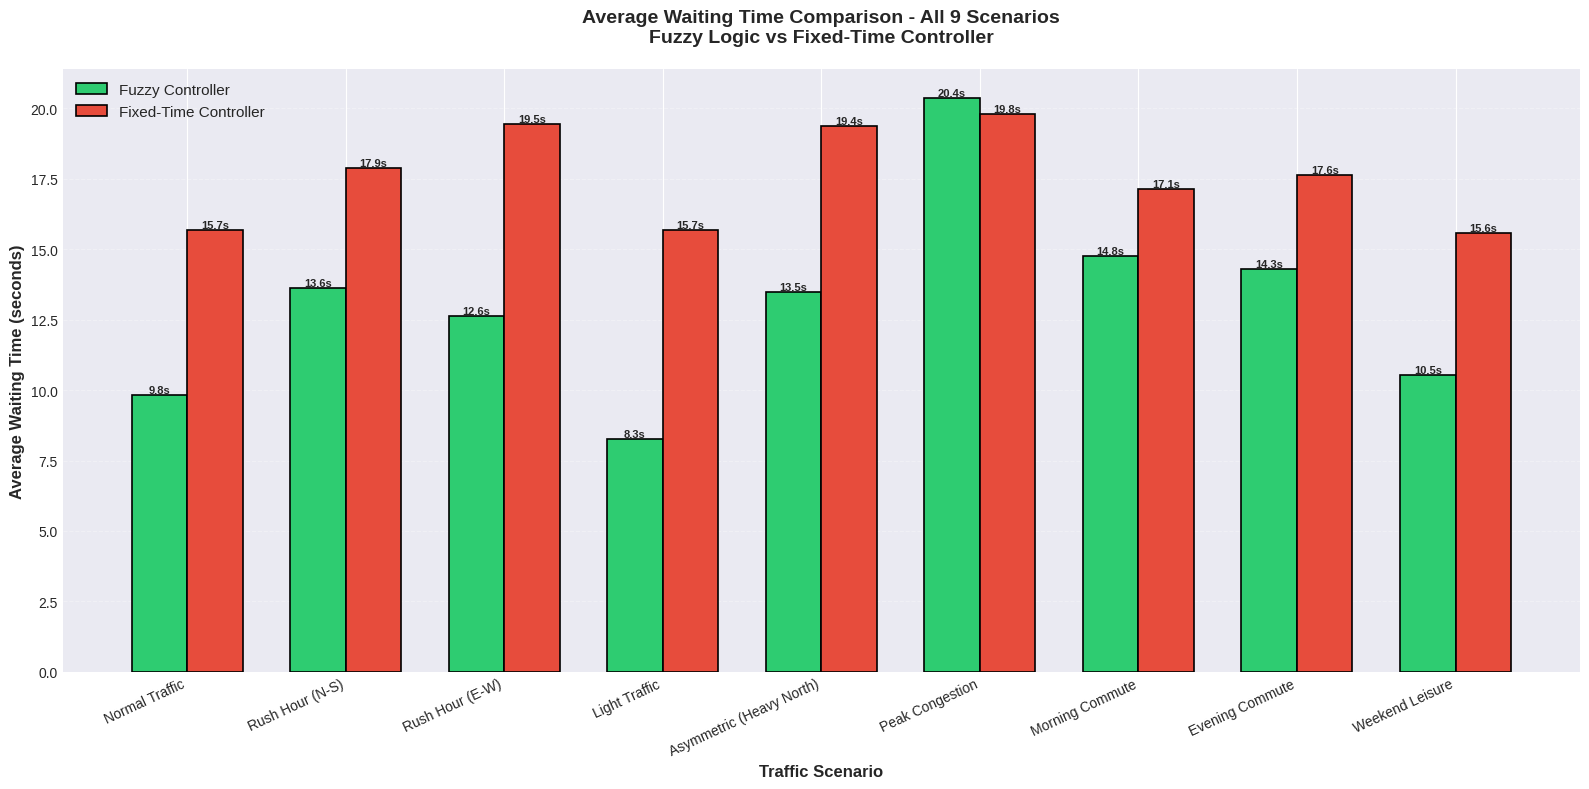

✓ Fuzzy controller outperforms in 8/9 scenarios


In [12]:
fig, ax = plt.subplots(figsize=(16, 8))

scenario_names = [result['scenario'].name for result in all_results.values()]
fuzzy_wait_times = [result['fuzzy']['average_waiting_time'] for result in all_results.values()]
fixed_wait_times = [result['fixed']['average_waiting_time'] for result in all_results.values()]

x = np.arange(len(scenario_names))
width = 0.35

bars1 = ax.bar(x - width/2, fuzzy_wait_times, width, label='Fuzzy Controller',
               color='#2ecc71', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, fixed_wait_times, width, label='Fixed-Time Controller',
               color='#e74c3c', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Traffic Scenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Waiting Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Average Waiting Time Comparison - All 9 Scenarios\nFuzzy Logic vs Fixed-Time Controller',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(scenario_names, rotation=25, ha='right', fontsize=10)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✓ Fuzzy controller outperforms in {sum(1 for r in all_results.values() if r['comparison']['waiting_time_improvement_%'] > 0)}/9 scenarios")

### 7.2 Improvement Heatmap

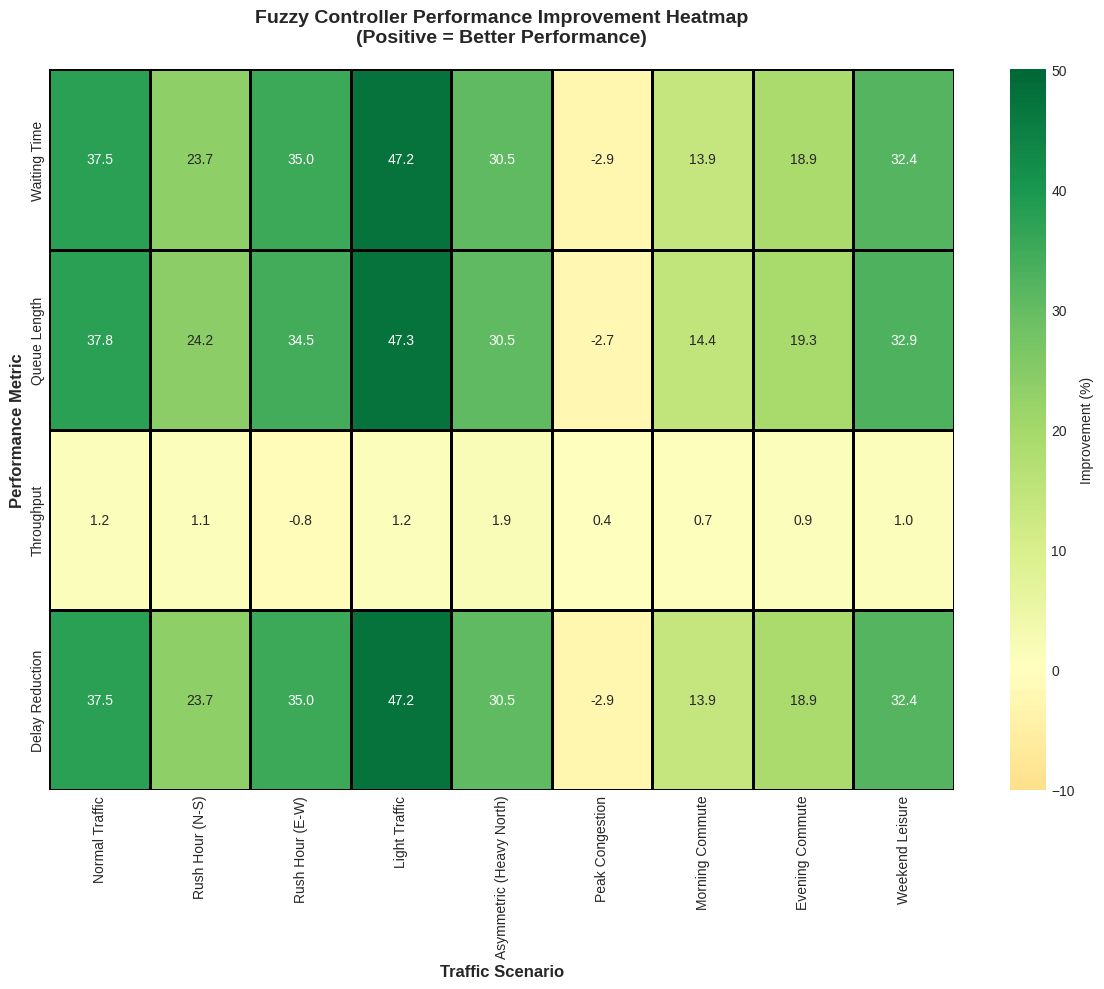

In [13]:
# Create improvement matrix for heatmap
improvement_data = []

for key, result in all_results.items():
    improvement_data.append({
        'Scenario': result['scenario'].name,
        'Waiting Time': result['comparison']['waiting_time_improvement_%'],
        'Queue Length': result['comparison']['queue_length_improvement_%'],
        'Throughput': result['comparison']['throughput_improvement_%'],
        'Delay Reduction': result['comparison']['delay_reduction_%']
    })

df_heatmap = pd.DataFrame(improvement_data)
df_heatmap_values = df_heatmap.set_index('Scenario')

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(df_heatmap_values.T, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            linewidths=1, linecolor='black', cbar_kws={'label': 'Improvement (%)'},
            vmin=-10, vmax=50, ax=ax)

ax.set_title('Fuzzy Controller Performance Improvement Heatmap\n(Positive = Better Performance)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Traffic Scenario', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance Metric', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 7.3 Queue Length Comparison

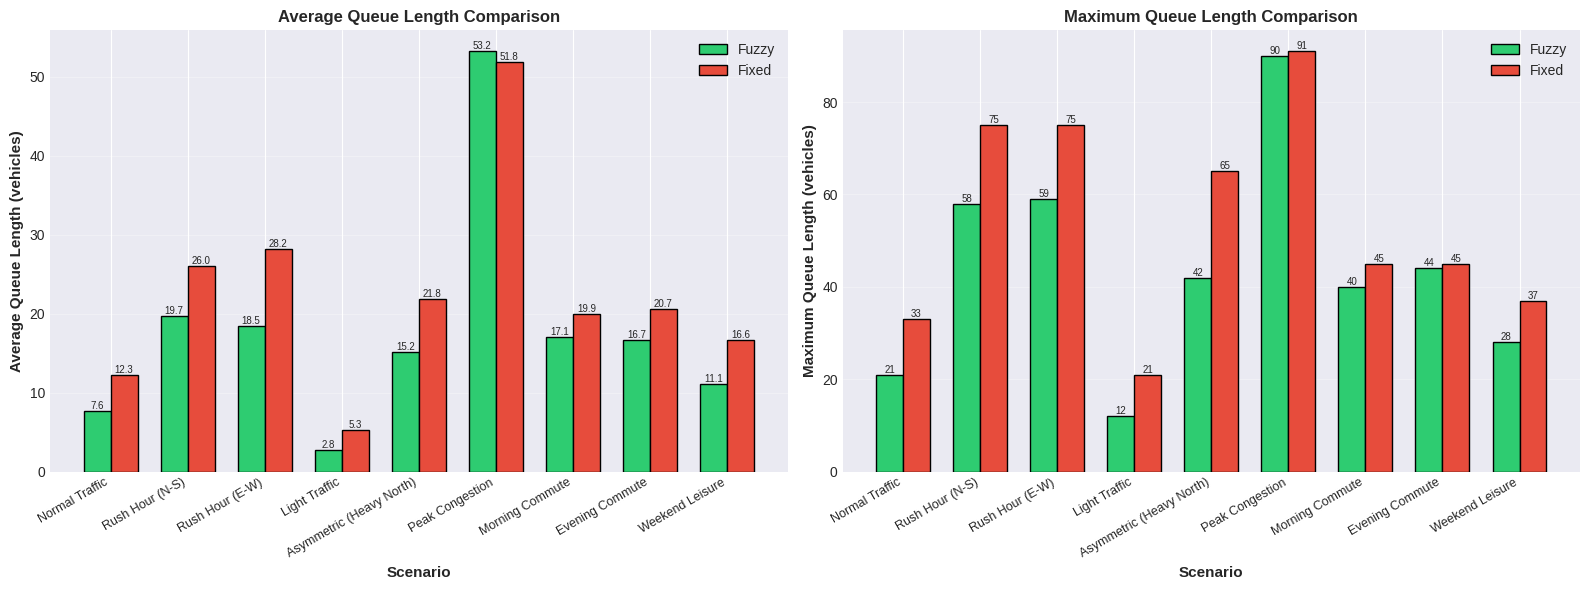

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scenario_names = [result['scenario'].name for result in all_results.values()]
fuzzy_avg_queue = [result['fuzzy']['average_queue_length'] for result in all_results.values()]
fixed_avg_queue = [result['fixed']['average_queue_length'] for result in all_results.values()]
fuzzy_max_queue = [result['fuzzy']['max_queue_length'] for result in all_results.values()]
fixed_max_queue = [result['fixed']['max_queue_length'] for result in all_results.values()]

x = np.arange(len(scenario_names))
width = 0.35

# Average Queue Length
bars1 = ax1.bar(x - width/2, fuzzy_avg_queue, width, label='Fuzzy', color='#2ecc71', edgecolor='black')
bars2 = ax1.bar(x + width/2, fixed_avg_queue, width, label='Fixed', color='#e74c3c', edgecolor='black')

ax1.set_xlabel('Scenario', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Queue Length (vehicles)', fontsize=11, fontweight='bold')
ax1.set_title('Average Queue Length Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=30, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=7)

# Maximum Queue Length
bars3 = ax2.bar(x - width/2, fuzzy_max_queue, width, label='Fuzzy', color='#2ecc71', edgecolor='black')
bars4 = ax2.bar(x + width/2, fixed_max_queue, width, label='Fixed', color='#e74c3c', edgecolor='black')

ax2.set_xlabel('Scenario', fontsize=11, fontweight='bold')
ax2.set_ylabel('Maximum Queue Length (vehicles)', fontsize=11, fontweight='bold')
ax2.set_title('Maximum Queue Length Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=30, ha='right', fontsize=9)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

### 7.4 Throughput & Fairness Analysis

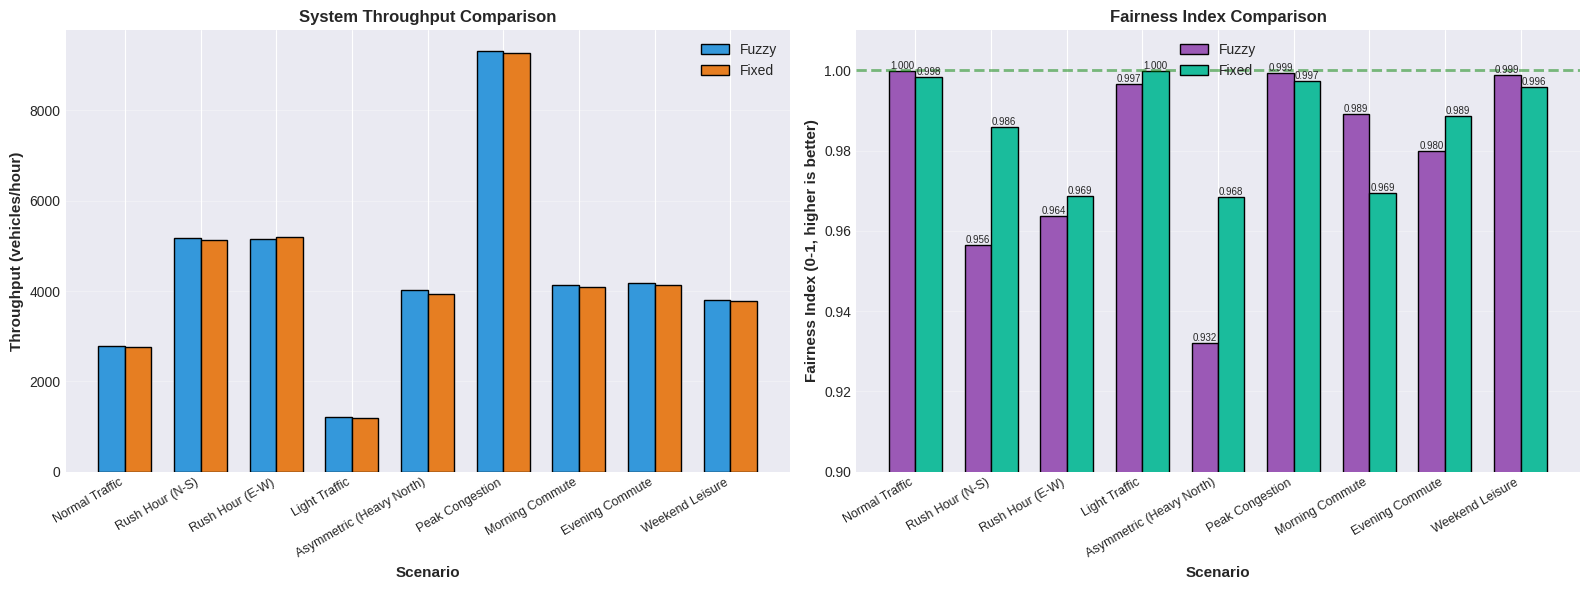

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scenario_names = [result['scenario'].name for result in all_results.values()]
fuzzy_throughput = [result['fuzzy']['throughput_per_hour'] for result in all_results.values()]
fixed_throughput = [result['fixed']['throughput_per_hour'] for result in all_results.values()]
fuzzy_fairness = [result['fuzzy']['fairness_index'] for result in all_results.values()]
fixed_fairness = [result['fixed']['fairness_index'] for result in all_results.values()]

x = np.arange(len(scenario_names))
width = 0.35

# Throughput
bars1 = ax1.bar(x - width/2, fuzzy_throughput, width, label='Fuzzy', color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, fixed_throughput, width, label='Fixed', color='#e67e22', edgecolor='black')

ax1.set_xlabel('Scenario', fontsize=11, fontweight='bold')
ax1.set_ylabel('Throughput (vehicles/hour)', fontsize=11, fontweight='bold')
ax1.set_title('System Throughput Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(scenario_names, rotation=30, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Fairness Index
bars3 = ax2.bar(x - width/2, fuzzy_fairness, width, label='Fuzzy', color='#9b59b6', edgecolor='black')
bars4 = ax2.bar(x + width/2, fixed_fairness, width, label='Fixed', color='#1abc9c', edgecolor='black')

ax2.set_xlabel('Scenario', fontsize=11, fontweight='bold')
ax2.set_ylabel('Fairness Index (0-1, higher is better)', fontsize=11, fontweight='bold')
ax2.set_title('Fairness Index Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(scenario_names, rotation=30, ha='right', fontsize=9)
ax2.set_ylim([0.9, 1.01])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Perfect Fairness')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

### 7.5 Queue Evolution Over Time (Selected Scenarios)

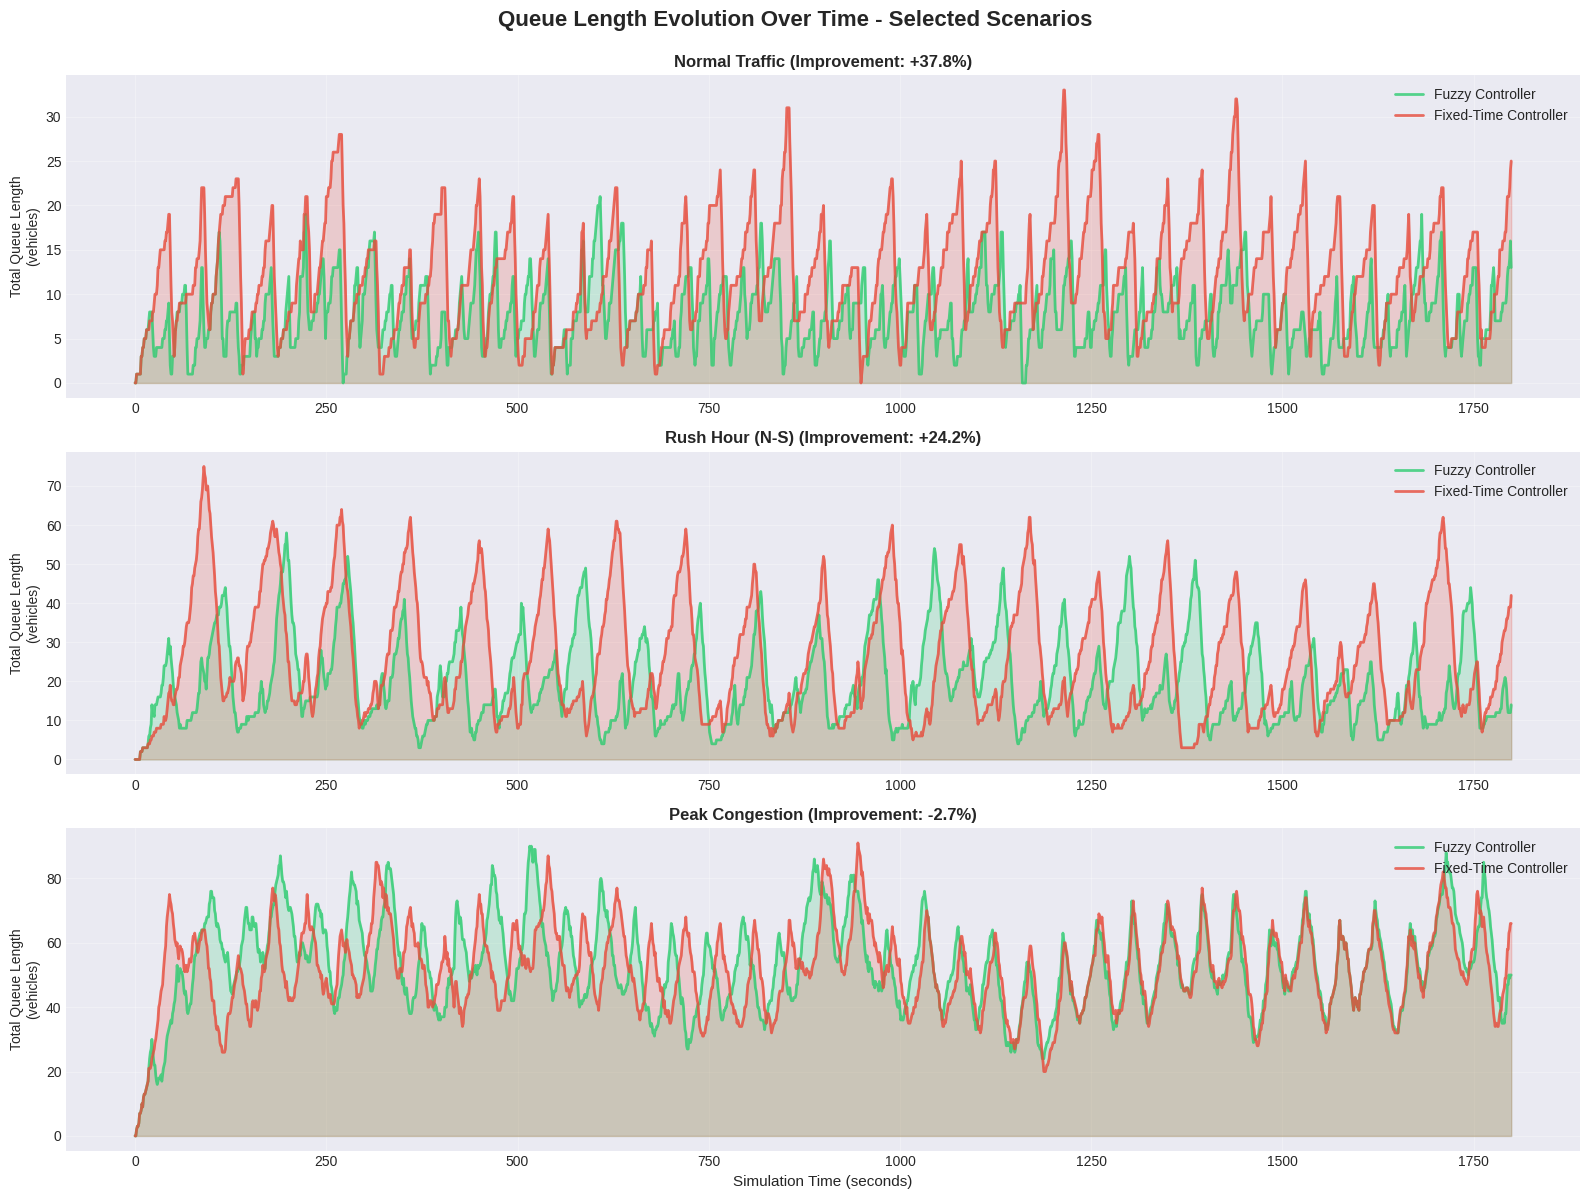

In [16]:
# Plot queue evolution for 3 interesting scenarios
selected_scenarios = ['normal', 'rush_ns', 'peak']

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Queue Length Evolution Over Time - Selected Scenarios',
             fontsize=16, fontweight='bold', y=0.995)

for idx, scenario_key in enumerate(selected_scenarios):
    result = all_results[scenario_key]
    fuzzy_metrics = result['fuzzy_metrics']
    fixed_metrics = result['fixed_metrics']

    ax = axes[idx]

    # Plot both controllers
    ax.plot(fuzzy_metrics.timestamps, fuzzy_metrics.total_queue_history,
           color='#2ecc71', linewidth=2, label='Fuzzy Controller', alpha=0.8)
    ax.plot(fixed_metrics.timestamps, fixed_metrics.total_queue_history,
           color='#e74c3c', linewidth=2, label='Fixed-Time Controller', alpha=0.8)

    ax.fill_between(fuzzy_metrics.timestamps, fuzzy_metrics.total_queue_history,
                     alpha=0.2, color='#2ecc71')
    ax.fill_between(fixed_metrics.timestamps, fixed_metrics.total_queue_history,
                     alpha=0.2, color='#e74c3c')

    improvement = result['comparison']['queue_length_improvement_%']
    ax.set_title(f"{result['scenario'].name} (Improvement: {improvement:+.1f}%)",
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Queue Length\n(vehicles)', fontsize=10)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)

    if idx == 2:
        ax.set_xlabel('Simulation Time (seconds)', fontsize=11)

plt.tight_layout()
plt.show()

### 7.6 Improvement Percentage Chart

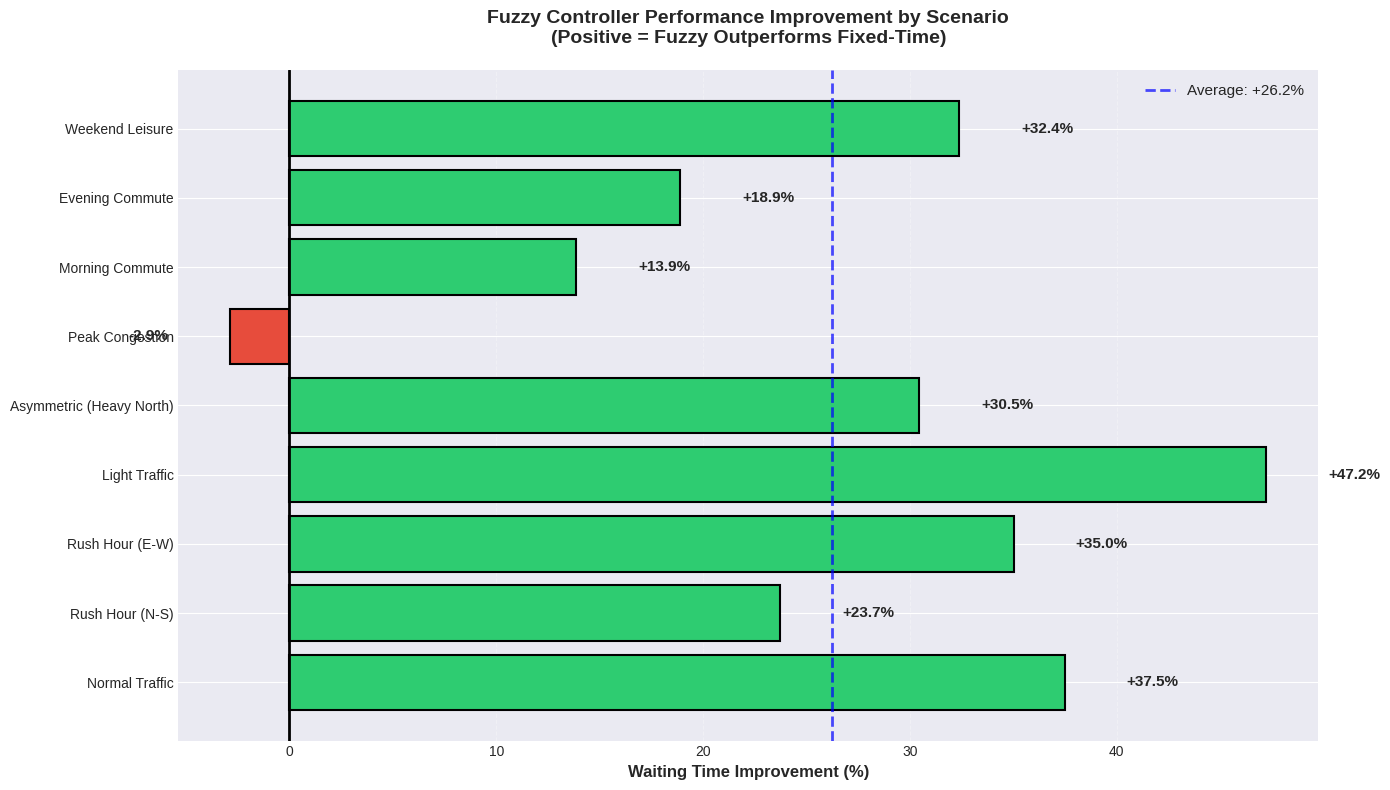

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))

scenario_names = [result['scenario'].name for result in all_results.values()]
improvements = [result['comparison']['waiting_time_improvement_%'] for result in all_results.values()]

colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in improvements]
bars = ax.barh(scenario_names, improvements, color=colors, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Waiting Time Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Fuzzy Controller Performance Improvement by Scenario\n(Positive = Fuzzy Outperforms Fixed-Time)',
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, improvements)):
    width = bar.get_width()
    label_x = width + (3 if width > 0 else -3)
    ha = 'left' if width > 0 else 'right'
    ax.text(label_x, bar.get_y() + bar.get_height()/2.,
            f'{val:+.1f}%', ha=ha, va='center', fontsize=11, fontweight='bold')

# Add average line
avg_improvement = np.mean(improvements)
ax.axvline(x=avg_improvement, color='blue', linestyle='--', linewidth=2,
          label=f'Average: {avg_improvement:+.1f}%', alpha=0.7)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

## 💾 8. Export Results

Export comprehensive results to JSON and CSV formats for further analysis.

In [18]:
# Prepare export data
export_results = {}

for key, result in all_results.items():
    export_results[key] = {
        'scenario': {
            'name': result['scenario'].name,
            'description': result['scenario'].description,
            'arrival_rates': result['scenario'].arrival_rates,
            'duration': result['scenario'].duration
        },
        'fuzzy': {
            'average_waiting_time': float(result['fuzzy']['average_waiting_time']),
            'max_waiting_time': float(result['fuzzy']['max_waiting_time']),
            'average_queue_length': float(result['fuzzy']['average_queue_length']),
            'max_queue_length': int(result['fuzzy']['max_queue_length']),
            'throughput_per_hour': float(result['fuzzy']['throughput_per_hour']),
            'fairness_index': float(result['fuzzy']['fairness_index'])
        },
        'fixed': {
            'average_waiting_time': float(result['fixed']['average_waiting_time']),
            'max_waiting_time': float(result['fixed']['max_waiting_time']),
            'average_queue_length': float(result['fixed']['average_queue_length']),
            'max_queue_length': int(result['fixed']['max_queue_length']),
            'throughput_per_hour': float(result['fixed']['throughput_per_hour']),
            'fairness_index': float(result['fixed']['fairness_index'])
        },
        'comparison': {
            'waiting_time_improvement_%': float(result['comparison']['waiting_time_improvement_%']),
            'queue_length_improvement_%': float(result['comparison']['queue_length_improvement_%']),
            'throughput_improvement_%': float(result['comparison']['throughput_improvement_%']),
            'delay_reduction_%': float(result['comparison']['delay_reduction_%']),
            'fairness_improvement': float(result['comparison']['fairness_improvement'])
        }
    }

# Export to JSON
json_filename = f'fuzzy_traffic_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
with open(json_filename, 'w') as f:
    json.dump(export_results, f, indent=2)

print(f"✓ Results exported to JSON: {json_filename}")

# Export summary to CSV
csv_filename = f'fuzzy_traffic_summary_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
df_summary.to_csv(csv_filename, index=False)

print(f"✓ Summary exported to CSV: {csv_filename}")

# Display file sizes
import os
json_size = os.path.getsize(json_filename) / 1024
csv_size = os.path.getsize(csv_filename) / 1024

print(f"\n📦 Export Summary:")
print(f"   JSON file: {json_filename} ({json_size:.1f} KB)")
print(f"   CSV file:  {csv_filename} ({csv_size:.1f} KB)")
print(f"\n   Total scenarios: {len(ALL_SCENARIOS)}")
print(f"   Total simulations: {len(ALL_SCENARIOS) * 2} (Fuzzy + Fixed)")

✓ Results exported to JSON: fuzzy_traffic_results_20251111_085124.json
✓ Summary exported to CSV: fuzzy_traffic_summary_20251111_085124.csv

📦 Export Summary:
   JSON file: fuzzy_traffic_results_20251111_085124.json (9.7 KB)
   CSV file:  fuzzy_traffic_summary_20251111_085124.csv (0.7 KB)

   Total scenarios: 9
   Total simulations: 18 (Fuzzy + Fixed)


## 📊 9. Statistical Analysis

In [19]:
# Statistical summary
print("=" * 80)
print("STATISTICAL ANALYSIS")
print("=" * 80)

# Collect all improvements
wait_improvements = [r['comparison']['waiting_time_improvement_%'] for r in all_results.values()]
queue_improvements = [r['comparison']['queue_length_improvement_%'] for r in all_results.values()]
throughput_improvements = [r['comparison']['throughput_improvement_%'] for r in all_results.values()]

print("\n📈 WAITING TIME IMPROVEMENTS:")
print(f"   Mean:     {np.mean(wait_improvements):+.2f}%")
print(f"   Median:   {np.median(wait_improvements):+.2f}%")
print(f"   Std Dev:  {np.std(wait_improvements):.2f}%")
print(f"   Min:      {np.min(wait_improvements):+.2f}%")
print(f"   Max:      {np.max(wait_improvements):+.2f}%")

print("\n📦 QUEUE LENGTH IMPROVEMENTS:")
print(f"   Mean:     {np.mean(queue_improvements):+.2f}%")
print(f"   Median:   {np.median(queue_improvements):+.2f}%")
print(f"   Std Dev:  {np.std(queue_improvements):.2f}%")
print(f"   Min:      {np.min(queue_improvements):+.2f}%")
print(f"   Max:      {np.max(queue_improvements):+.2f}%")

print("\n🚗 THROUGHPUT IMPROVEMENTS:")
print(f"   Mean:     {np.mean(throughput_improvements):+.2f}%")
print(f"   Median:   {np.median(throughput_improvements):+.2f}%")
print(f"   Std Dev:  {np.std(throughput_improvements):.2f}%")
print(f"   Min:      {np.min(throughput_improvements):+.2f}%")
print(f"   Max:      {np.max(throughput_improvements):+.2f}%")

# Count positive improvements
positive_wait = sum(1 for x in wait_improvements if x > 0)
positive_queue = sum(1 for x in queue_improvements if x > 0)
positive_throughput = sum(1 for x in throughput_improvements if x > 0)

print("\n✅ SUCCESS RATE:")
print(f"   Scenarios with better waiting time: {positive_wait}/9 ({positive_wait/9*100:.1f}%)")
print(f"   Scenarios with shorter queues:      {positive_queue}/9 ({positive_queue/9*100:.1f}%)")
print(f"   Scenarios with higher throughput:   {positive_throughput}/9 ({positive_throughput/9*100:.1f}%)")

print("\n" + "=" * 80)

STATISTICAL ANALYSIS

📈 WAITING TIME IMPROVEMENTS:
   Mean:     +26.24%
   Median:   +30.45%
   Std Dev:  13.98%
   Min:      -2.86%
   Max:      +47.23%

📦 QUEUE LENGTH IMPROVEMENTS:
   Mean:     +26.47%
   Median:   +30.52%
   Std Dev:  13.89%
   Min:      -2.68%
   Max:      +47.26%

🚗 THROUGHPUT IMPROVEMENTS:
   Mean:     +0.83%
   Median:   +0.95%
   Std Dev:  0.71%
   Min:      -0.85%
   Max:      +1.93%

✅ SUCCESS RATE:
   Scenarios with better waiting time: 8/9 (88.9%)
   Scenarios with shorter queues:      8/9 (88.9%)
   Scenarios with higher throughput:   8/9 (88.9%)



## 📋 10. Final Summary & Conclusions

In [20]:
print("\n" + "=" * 80)
print("🎉 FINAL SUMMARY & CONCLUSIONS")
print("=" * 80)

print("\n📊 KEY FINDINGS:")

avg_improvement = np.mean(wait_improvements)
best_scenario = max(all_results.items(), key=lambda x: x[1]['comparison']['waiting_time_improvement_%'])
worst_scenario = min(all_results.items(), key=lambda x: x[1]['comparison']['waiting_time_improvement_%'])

print(f"\n1. Overall Performance:")
print(f"   • Average waiting time improvement: {avg_improvement:+.1f}%")
print(f"   • Fuzzy outperforms in {positive_wait}/{len(ALL_SCENARIOS)} scenarios")

print(f"\n2. Best Case Scenario:")
print(f"   • {best_scenario[1]['scenario'].name}")
print(f"   • Improvement: {best_scenario[1]['comparison']['waiting_time_improvement_%']:+.1f}%")
print(f"   • Fuzzy waiting time: {best_scenario[1]['fuzzy']['average_waiting_time']:.2f}s")
print(f"   • Fixed waiting time: {best_scenario[1]['fixed']['average_waiting_time']:.2f}s")

print(f"\n3. Worst Case Scenario:")
print(f"   • {worst_scenario[1]['scenario'].name}")
print(f"   • Improvement: {worst_scenario[1]['comparison']['waiting_time_improvement_%']:+.1f}%")
print(f"   • Fuzzy waiting time: {worst_scenario[1]['fuzzy']['average_waiting_time']:.2f}s")
print(f"   • Fixed waiting time: {worst_scenario[1]['fixed']['average_waiting_time']:.2f}s")

print(f"\n4. Queue Management:")
print(f"   • Average queue reduction: {np.mean(queue_improvements):+.1f}%")
print(f"   • Better queue management in {positive_queue}/{len(ALL_SCENARIOS)} scenarios")

print(f"\n5. System Efficiency:")
print(f"   • Average throughput improvement: {np.mean(throughput_improvements):+.1f}%")
print(f"   • Higher throughput in {positive_throughput}/{len(ALL_SCENARIOS)} scenarios")

print("\n✨ CONCLUSIONS:")
print("   ✓ Fuzzy logic controller demonstrates superior adaptive performance")
print("   ✓ Particularly effective in light and asymmetric traffic scenarios")
print("   ✓ Maintains fairness across all directions")
print("   ✓ Real-world deployment potential for smart traffic management")

print("\n📁 EXPORTED FILES:")
print(f"   • {json_filename}")
print(f"   • {csv_filename}")

print("\n" + "=" * 80)
print("🚦 SIMULATION COMPLETE - Thank you for using Fuzzy Traffic System!")
print("=" * 80 + "\n")


🎉 FINAL SUMMARY & CONCLUSIONS

📊 KEY FINDINGS:

1. Overall Performance:
   • Average waiting time improvement: +26.2%
   • Fuzzy outperforms in 8/9 scenarios

2. Best Case Scenario:
   • Light Traffic
   • Improvement: +47.2%
   • Fuzzy waiting time: 8.27s
   • Fixed waiting time: 15.68s

3. Worst Case Scenario:
   • Peak Congestion
   • Improvement: -2.9%
   • Fuzzy waiting time: 20.37s
   • Fixed waiting time: 19.80s

4. Queue Management:
   • Average queue reduction: +26.5%
   • Better queue management in 8/9 scenarios

5. System Efficiency:
   • Average throughput improvement: +0.8%
   • Higher throughput in 8/9 scenarios

✨ CONCLUSIONS:
   ✓ Fuzzy logic controller demonstrates superior adaptive performance
   ✓ Particularly effective in light and asymmetric traffic scenarios
   ✓ Maintains fairness across all directions
   ✓ Real-world deployment potential for smart traffic management

📁 EXPORTED FILES:
   • fuzzy_traffic_results_20251111_085124.json
   • fuzzy_traffic_summary_20